In [2]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import joblib

# --- Visualization ---
import seaborn as sns
import matplotlib.pyplot as plt

# --- Preprocessing & Modeling ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import shap

# --- Display Settings ---
# Ensure plots are displayed correctly in the notebook
%matplotlib inline

c:\Users\legio\OneDrive\Desktop\projects\Proactive Failure Detection for Industrial Machinery\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the dataset from the CSV file
df = pd.read_csv('ai4i2020.csv')

# Display basic information and the first 5 rows
print("--- Dataset Info ---")
df.info()
print("\n--- First 5 Rows ---")
df.head()

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes:

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


--- Target Variable Distribution ---
Machine failure
0    9661
1     339
Name: count, dtype: int64

--- Descriptive Statistics ---
               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]  Machine failure  \
count            10000.000000  10000.000000     10000.000000     10000.000000   
mean              1538.776100     39.986910       107.951000         0.033900   
std          

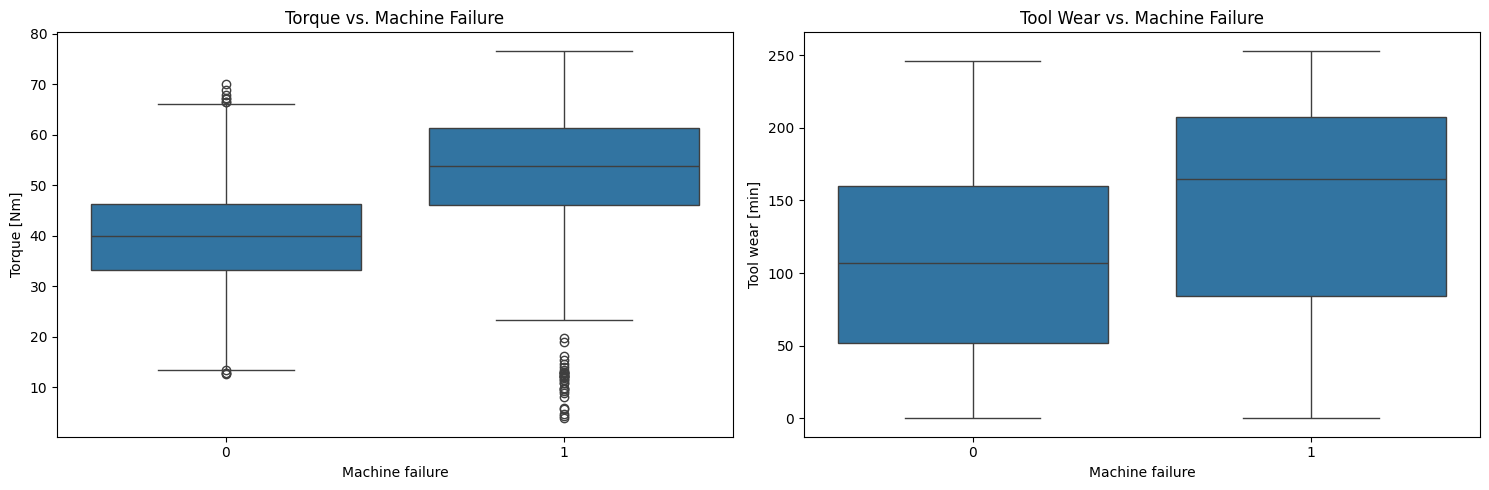


--- Pairplot of Feature Interactions ---


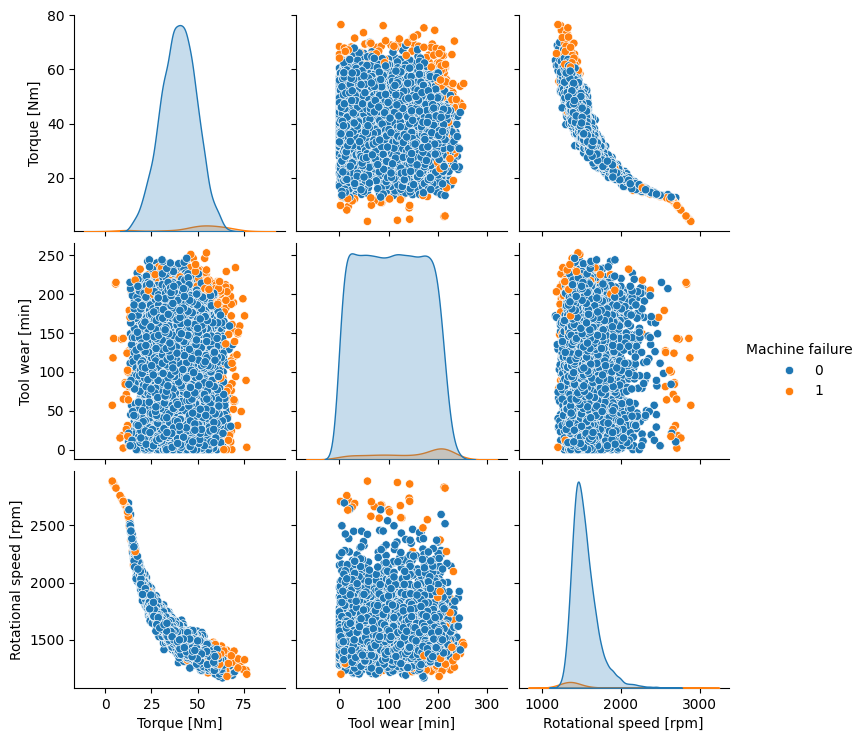

In [4]:
# --- Statistical Summary ---
print("--- Target Variable Distribution ---")
print(df['Machine failure'].value_counts())
print("\n--- Descriptive Statistics ---")
print(df.describe())


# --- Visualization 1: Box Plots for Key Features ---
print("\n--- Visualizing Key Features vs. Failure ---")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x='Machine failure', y='Torque [Nm]', data=df, ax=axes[0])
axes[0].set_title('Torque vs. Machine Failure')
sns.boxplot(x='Machine failure', y='Tool wear [min]', data=df, ax=axes[1])
axes[1].set_title('Tool Wear vs. Machine Failure')
plt.tight_layout()
plt.show()


# --- Visualization 2: Pairplot for Interactions ---
print("\n--- Pairplot of Feature Interactions ---")
# Select a few key features plus the target for the pairplot
key_features_df = df[['Torque [Nm]', 'Tool wear [min]', 'Rotational speed [rpm]', 'Machine failure']]

# Create the pairplot, colored by machine failure status
sns.pairplot(key_features_df, hue='Machine failure', diag_kind='kde')
plt.show()

In [5]:
# Create the df_processed DataFrame for modeling
df_processed = df.drop(['UDI', 'Product ID'], axis=1)

# One-Hot Encode the 'Type' column
df_processed = pd.get_dummies(df_processed, columns=['Type'], drop_first=True)

# Create new, physically meaningful features
df_processed['Power [W]'] = df_processed['Torque [Nm]'] * df_processed['Rotational speed [rpm]']
df_processed['Temp_Diff [K]'] = df_processed['Process temperature [K]'] - df_processed['Air temperature [K]']

print("df_processed DataFrame with new features created successfully!")
df_processed.head()

df_processed DataFrame with new features created successfully!


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_L,Type_M,Power [W],Temp_Diff [K]
0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,False,True,66382.8,10.5
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,True,False,65190.4,10.5
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,True,False,74001.2,10.4
3,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,True,False,56603.5,10.4
4,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,True,False,56320.0,10.5


In [6]:
# Define features (X) and target (y)
X = df_processed.drop('Machine failure', axis=1)
y = df_processed['Machine failure']

# Split data into training and testing sets, stratifying by the target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate weight for the positive class to handle imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Initialize and train the XGBoost Classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train_scaled, y_train)
print("Model training complete!")

Model training complete!


--- Classification Report ---
              precision    recall  f1-score   support

  No Failure       1.00      1.00      1.00      1932
     Failure       1.00      0.96      0.98        68

    accuracy                           1.00      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000


--- Confusion Matrix ---


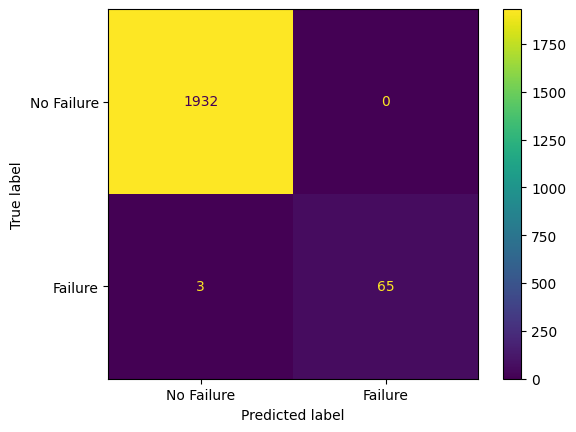

In [7]:
# Make predictions on the test set
preds = model.predict(X_test_scaled)

# Print the classification report for detailed metrics
print("--- Classification Report ---")
print(classification_report(y_test, preds, target_names=['No Failure', 'Failure']))

# Visualize the confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Failure', 'Failure'])
disp.plot()
plt.show()

--- SHAP Feature Importance ---


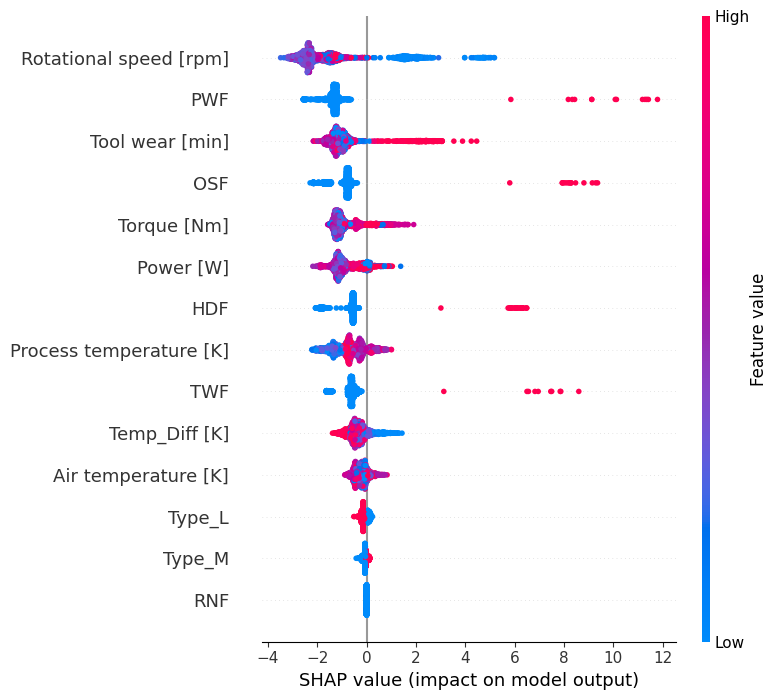

In [8]:
# Create a SHAP explainer to understand feature importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

# Create the summary plot
print("--- SHAP Feature Importance ---")
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [9]:
# Save the trained model and the scaler for later use
joblib.dump(model, 'failure_prediction_model.pkl')
joblib.dump(scaler, 'data_scaler.pkl')

print("Model and scaler have been saved successfully!")

Model and scaler have been saved successfully!


In [10]:
# --- 1. Load the Saved Model and Scaler ---
loaded_model = joblib.load('failure_prediction_model.pkl')
loaded_scaler = joblib.load('data_scaler.pkl')

# --- 2. Create New Sample Data ---
# The column list must include ALL features the model was trained on.
columns = [
    'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
    'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF',
    'Type_L', 'Type_M', 'Power [W]', 'Temp_Diff [K]'
]

# Scenario: High-risk machine (high torque, low speed)
sample_failure_risk = pd.DataFrame([
    [303.5, 312.8, 1250, 68.2, 190, 0, 0, 0, 1, 0, 0, 1, 85250, 9.3]
], columns=columns)

# --- 3. Test the "High Risk" Sample ---
print("--- Testing High-Risk Sample ---")

# Scale the new data using the loaded scaler
scaled_risk_sample = loaded_scaler.transform(sample_failure_risk)

# Make a prediction
prediction = loaded_model.predict(scaled_risk_sample)
prediction_proba = loaded_model.predict_proba(scaled_risk_sample)

# Print the results
if prediction[0] == 1:
    print("✅ Prediction: FAILURE IMMINENT (High Risk)")
    print(f"Confidence Score: {prediction_proba[0][1]:.2%}")
else:
    print("❌ Prediction: NO FAILURE (Healthy)")
    print(f"Confidence Score: {prediction_proba[0][0]:.2%}")

--- Testing High-Risk Sample ---
✅ Prediction: FAILURE IMMINENT (High Risk)
Confidence Score: 99.98%
